In [2]:
#class for managing interactions between model and podcast database.
import pickle
import time
import pandas as pd
import gensim
import numpy as np
import scipy
from sklearn import decomposition,mixture
import sklearn
from matplotlib import pyplot as plt, rcParams
rcParams.update({'font.size': 15})
from nltk.corpus import stopwords
import feedparser as fp
#import sqlite3
#from sqlalchemy.orm import scoped_session
#from sqlalchemy.orm import sessionmaker

class PodcastDB:
    #static class variables

    #initialize object
    def __init__(self,fid,model=None):
        if(fid is not None):
            self.podcastdb = pickle.load(fid)
            #sqlout = self.__querydb('SELECT collectionId,w2v FROM podcasts')
            self.w2vs = [v for v in self.podcastdb['w2v'].get_values()]
            #self.ids = [id for id in self.podcastdb['collectionId'].get_values()]
            self.npodcast = len(self.w2vs)
        else:
            raise ValueError('Object constructor must be called with a valid file ID')
            self.podcastdb = None
            self.w2vs = None
            #self.ids = None
            self.npodcast = 0
            
        if(isinstance(model,gensim.models.keyedvectors.Word2VecKeyedVectors)):
            self.model = model
        else:
            raise ValueError('Object constructor must be called with a valid model')
            self.model = None
            
        self.comparator = scipy.spatial.distance.cosine
        #self.reclean = re.compile('<.*?>')
        self.cleaner = Cleaner()

            
    #primary method. finds podcasts most similar to some word.
    def search(self,word,n_outputs=5):

        word = self.cleaner.preprocess_input(word)
        
        #ensures that object is properly initialized
        if((self.podcastdb is None) or (self.model is None)):
            raise ClassError('Object not properly initialized.')
            
        if(not word):
            raise ValueError('Input contains no valid words.')
        
        #ADD SQL QUERY HERE
        return self.podcastdb.iloc[self.__compare(self._evaluate(word)).argsort()[:n_outputs]]
        #return [self.podcastdb.loc[self.podcastdb['collectionId']==thisid] for thisid in bestID]
    

    #primary method. finds podcasts most similar to some word.
    def search_episodes(self,word,n_outputs=3,n_episodes=5,n_most_recent=10):
                
        #find the best podcasts, evaluate input
        pc_match = self.search(word,n_outputs)
        u = self._evaluate(self.cleaner.preprocess_input(word,rep_dash=True))
        
        #get the episodes associated with the best podcasts
        #get eps of each matching podcast
        ep_data = [self._get_eps(pc_match.iloc[i]['feedUrl']) for i in range(0,len(pc_match))] 
        #vectorize each episode
        ep_vec = [[self._evaluate(self.cleaner.preprocess_input(eps['entries'][i]['content'][0]['value'])) 
                   for i in range(0,min([n_most_recent,len(eps['entries'])]))] for eps in ep_data]

        #get relevant ep data
        sorted_eps = [np.array([self.comparator(u,v) for v in ev]).argsort()[:n_outputs] for ev in ep_vec]
        
        #return the data for the best eps
        return pc_match, [[e for e in eps['entries'][0:min([len(eps['entries']),n_outputs])]]
                          for eps in ep_data]

    #get the most recent n episodes associated with the best matching podcasts
    def _get_eps(self,url):
        try:
            return fp.parse(url)
        except:
            print('Error on ' + url)
            return (url,None)
    
    #apply internal model to a single word. 
    def _evaluate(self,word):
        if(isinstance(word,list)):
            return self.__evaluate_set(word)
        elif(isinstance(word,str)):
            #attempt to get vectorial representation of word.
            try:
                return self.model[word]
            except KeyError as e:
                return np.full([300,],np.nan)
        else:
            raise TypeError()
            
    #apply the model to a set of words and average them. 
    #this is simply ep2vec from other scripts.
    def __evaluate_set(self,words):
        #evaluate each word in 
        n = 0
        a = []
        for w in words:
            #attempt to evaluate vectorial representation of word.
            try:
                v = self.model[w]
                if((np.isnan(v).any() + np.isinf(v).any()) == 0):
                    a.append(v)
                    n += 1
            except KeyError as e:
                pass
        #if nothing was valid, return nan
        if(n==0):
            return np.full([300,], np.nan)
        #return average
        return np.mean(np.array(a),axis=0)
    
        #compares vector 
    def __compare(self,u):
        
        #return distances between vector and all our podcasts.
        return np.array([self.comparator(u,v) for v in self.w2vs])
    
#    def __querydb(self,query):
#        this_session = self.podcastdbcur()
#        results = this_session.query().from_statement(query).all()
#        print('This is the one: %s' % str(results))
#        return results
#        #return self.podcastdbcur.fetchall()
    


In [3]:
#These functions clean the data in various ways
import re
import html
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
import string

class Cleaner():
    
    def __init__(self):
        self.wp = WhitespaceTokenizer()
        self.reclean = re.compile('<.*?>')
        
    def remove_html_tags(self,text):
        return re.sub(self.reclean, ' ', text) 
    
    @classmethod
    def replace_newline(cls,text):
        return text.replace('\n',' ')
    
    @classmethod
    def replace_dash(cls,text,on=True):
        if(on):
            return text.replace('-',' ')
        else:
            return text

    #This removes non-alphabetical characters and makes everything lower case
    def clean(self,text,rep_dash=True):
        return ''.join(c for c in self.remove_html_tags(self.replace_dash(self.replace_newline(html.unescape(text.lower())),rep_dash)) 
                       if c in string.ascii_lowercase+' ')
    #this tokenizes intelligently

    def tokenize(self,text):
        #return TreebankWordTokenizer().tokenize(text)
        return self.wp.tokenize(text)
    #     words = WORD.findall(text)
    #     return words
    #this removes stopword tokens from a list of tokens
    def remove_stop_words(self,tokens):
        return [word for word in tokens if word not in stopwords.words('english')]
    
    #this will clean & tokenize a list of documents.
    
    def preprocess_input(self,words,rep_dash=True):
        return self.remove_stop_words(self.tokenize(self.clean(words,rep_dash)))

    def preprocess_documents(self,summaries,rep_dash=True):
        return [self.preprocess_input(s,rep_dash) for s in summaries]

    def prepare(self,text):
        return self.remove_html_tags(html.unescape(text))

In [4]:
#load in podcast df, gensim model, and put it in the database object.

floc = '/home/bmassi/Dropbox/professional/Insight/data/'
modelfname = 'GoogleNews-vectors-negative300.bin'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(floc+modelfname, binary=True)


In [5]:
podcastfname = 'podcast_df_subset_BIGDATA_REDUCED.pkl'#'podcast_df_subset_BIGDATA_1529347011.pkl'
with open(floc+podcastfname,'rb') as fid:
    podcastdb = PodcastDB(fid=fid,model=word2vec)

In [5]:
start_time = time.time()
output = podcastdb.search_episodes('How Anti-Immigration Passion Was Inflamed From the Fringe')
stop_time = time.time()
duration = stop_time - start_time
print(duration)

3.4122989177703857


In [14]:
output[1][2][1].links[1].href

'http://media.blubrry.com/wsws/www.wsws.org/asset/ca53a299-71f2-43a1-8c1c-473a754044dO/wsws20180621.mp3'

In [139]:
def format_episode_output(output):
    outstr = ''
    for i in range(0,output[0].shape[0]):
        outstr += output[0]['trackName'].iloc[i] + '\n'
        for j in range(0,len(output[1][i])):
            outstr += '\t\t' + output[1][i][j][0] + '\n'
            outstr += '\t\t\t\t' + podcastdb.remove_html_tags(output[1][i][j][1][0].value) + '\n'
    return outstr

print(format_episode_output(output))

LL Decker & Assiciates, Inc.
		Baseball and Temporal Communities
				This podcast illustrates how temporal communities operate to establish rules and standards for member behavior.
		Over My Dead Body!
				2008-07-10: NIMBY-ism and the polarity of voters
Keys To The House
		Republicans Hold Back Blue Wave, But Democrats Avoid Shutouts In California Primary
				California's contentious congressional races in Southern California brought in millions of dollars in campaign spending from national Democratic organizations that previously ignored these districts.
Host Ben Bradford asks political strategists whether the choice to spend big bucks paid off. Experts also talk about the "political chess game" that the parties played in order to succeed under California's "top-two" primary system. And they weigh in on each party&rsquo;s advantages and challenges going into the general election.
Guests:
Christine Mai-Duc Political Reporter LA Times @cmaiduc
Darry Sragow Attorney/Former Democratic Po

In [5]:
#Fit a gaussian mixture model for clustering to see how well topics are separated in vector space.
import numpy as np

n_components=10

#pull out podcast vectors and fit.
X = np.array(podcastdb.w2vs)#training examples
print(X.shape)
gmm = mixture.GaussianMixture(n_components=n_components)
gmm.fit(X)

X_labels = gmm.predict(X)

(31311, 300)


Text(0.5,1,'Clusters of podcast vectors (21.0% variance)')

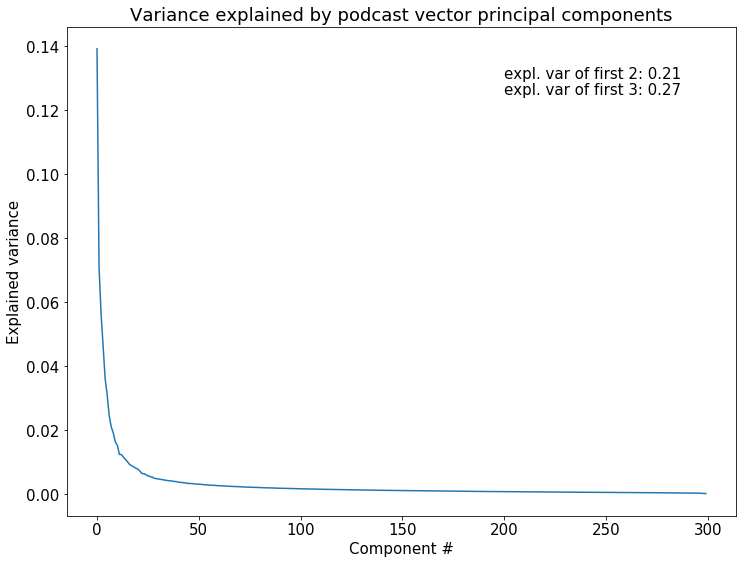

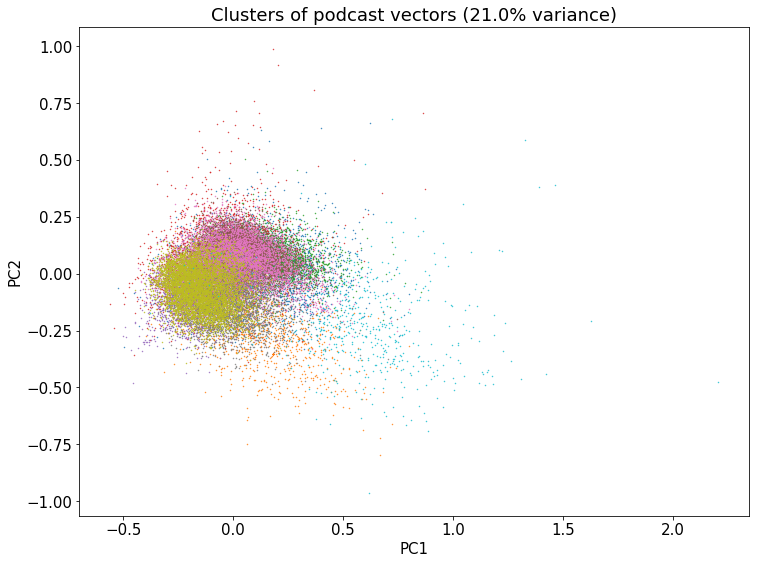

In [7]:
#Perform PCA to examine how explained variance is distributed across principal components. 
from sklearn import decomposition,mixture
import sklearn
from matplotlib import pyplot as plt, rcParams
import matplotlib
rcParams.update({'font.size': 15})

X = np.array(podcastdb.w2vs)
pca = sklearn.decomposition.PCA()
pca.fit(X)

plt.figure(figsize=[12,9])
plt.plot(range(0,len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)
plt.xlabel('Component #')
plt.ylabel('Explained variance')
plt.title('Variance explained by podcast vector principal components')
plt.text(200,.13,'expl. var of first 2: %.2f' % sum(pca.explained_variance_ratio_[0:2]))
plt.text(200,.125,'expl. var of first 3: %.2f' % sum(pca.explained_variance_ratio_[0:3]))

#reduce data to first 2 dimensions and plot according to cluster membership. 
ndim = 2
X_reduced = np.matmul(X-np.mean(X, axis=0),pca.components_[0:ndim].T)

cmap = plt.get_cmap('tab10')
plt.figure(figsize=[12,9])
for l in np.unique(X_labels):
    X_thiscluster = X_reduced[X_labels==l,:]
    plt.scatter(X_thiscluster[:,0],X_thiscluster[:,1],s=.2,c=cmap(l))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters of podcast vectors (%.1f%% variance)' % sum(100*pca.explained_variance_ratio_[0:2]))

In [4]:
#Validate model. Try to predict topics using xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

categories = podcastdb.podcastdb['primaryGenreName'].drop_duplicates()


labeler = LabelEncoder()
labeler = labeler.fit(podcastdb.podcastdb['primaryGenreName'])
X = np.array(podcastdb.w2vs)
encoded_labels = labeler.transform(podcastdb.podcastdb['primaryGenreName'])

seed = int(time.time())
test_size = .2
print("seed = %d" % (seed))
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=test_size, random_state=seed)

#train test split
#dfljk;sdal;k

seed = 1529373901


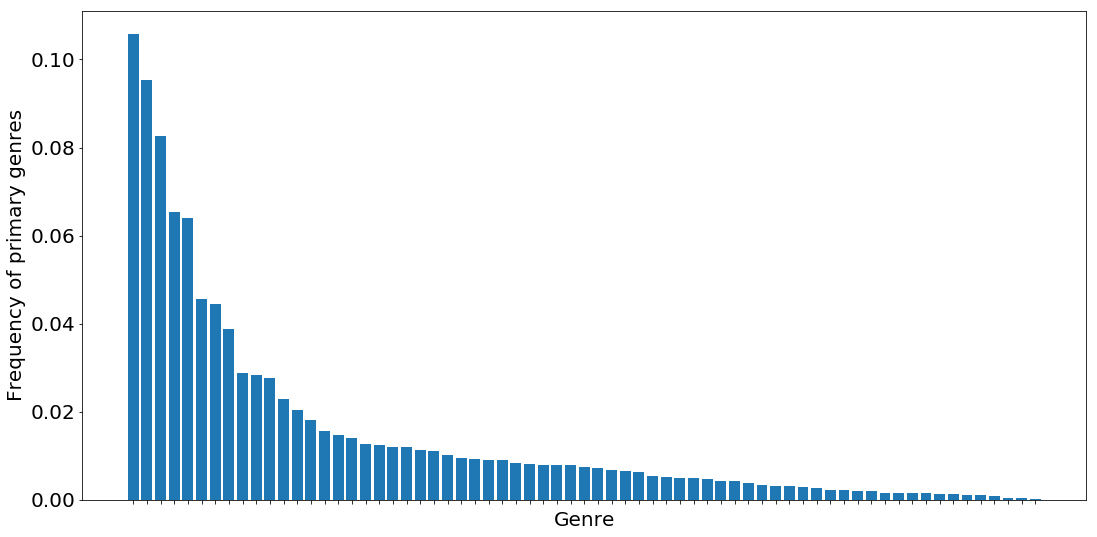

In [41]:
#Examine class distribution in test, train, and overall
import numpy as np
rcParams.update({'font.size': 20})

#pull out unique labels and count them
unique, counts = np.unique(podcastdb.podcastdb['primaryGenreName'], return_counts=True)
histdict = dict(zip(unique, counts))
names = list(histdict.keys())
values = list(histdict.values())

        
#compute "chance" frequency in two ways
#method 1: guess most common class always
guess_most_common = np.mean(names[np.argmax(values)]==podcastdb.podcastdb['primaryGenreName'])
#method 2: guess classes randomly proportional to their frequency

yval = values/sum(values)
inds = yval.argsort()[::-1][:len(yval)]
fig,ax = plt.subplots(1,1,figsize=[18,9])
ax.bar([names[i] for i in inds],[yval[i] for i in inds])
ax.set_xticklabels(['']*len(names))
ax.set_xlabel('Genre')
ax.set_ylabel('Frequency of primary genres')
for tick in ax.get_xticklabels():
        tick.set_rotation(90)
#ax.text(30,0.08,'Most frequent class: %.2f' % guess_most_common)

In [14]:
guess_most_common

0.10581942027912486

In [7]:
from sklearn import linear_model

lreg = linear_model.LogisticRegressionCV(multi_class='multinomial',solver='newton-cg')
lreg.fit(X_train,y_train)


/home/bmassi/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='newton-cg',
           tol=0.0001, verbose=0)

In [11]:
y_pred = lreg.predict(X_test)
predictions = [round(value) for value in y_pred]

np.mean(predictions==y_test)

array([65, 60, 25, ..., 11,  0, 60])

In [8]:
#gradient boosted trees
import xgboost

model = xgboost.XGBClassifier(nthread=8)
print('Starting fit!')
model.fit(X_train, y_train)
print('Fit done!')
print(model)


Starting fit!
Fit done!
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=8, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


/home/bmassi/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [12]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
np.mean(predictions==y_test)

/home/bmassi/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.473730462620049

In [14]:
floc = '/home/bmassi/Dropbox/professional/Insight/data/'
fname = 'validation_models_' + str(int(time.time()))
with open(floc+fname,'wb') as fid:
    pickle.dump({'X_train':X_train,'X_test':X_test,'y_train':y_train,'y_test':y_test,'xgboost_model':model,'linear_model':lreg},fid)

In [17]:
import pickle

floc = '/home/bmassi/Dropbox/professional/Insight/data/'
fname = 'validation_models_1529417024'
with open(floc+fname,'rb') as fid:
    model_stats = pickle.load(fid)

In [22]:
lin_acc = np.mean(model_stats['linear_model'].predict(model_stats['X_test'])==model_stats['y_test'])
xg_acc = np.mean(model_stats['xgboost_model'].predict(model_stats['X_test'])==model_stats['y_test'])

/home/bmassi/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(-0.5, 1.5)

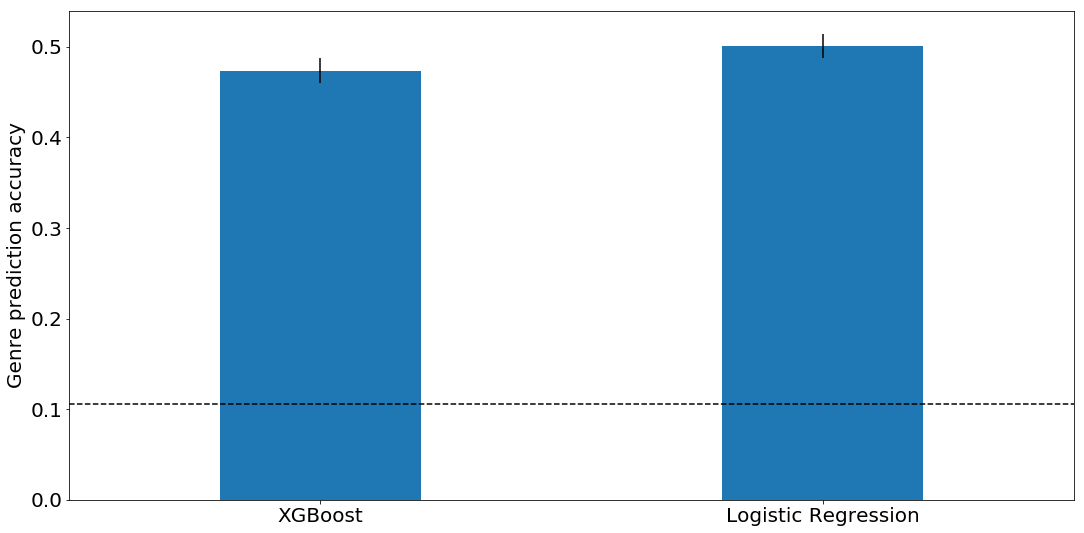

In [42]:
import scipy

fig,ax = plt.subplots(1,1,figsize=[18,9])
ax.bar(['XGBoost','Logistic Regression'],[xg_acc,lin_acc],yerr=scipy.stats.sem([xg_acc,lin_acc]),width=.4)
ax.plot([-.5,1.5],[guess_most_common,guess_most_common],'--k')
ax.set_ylabel('Genre prediction accuracy')
ax.set_xlim([-.5,1.5])

In [6]:
#Look at distribution of podcast similarity to articles
import pickle
import scipy
    
#Load up article database
articlesfloc = '/home/bmassi/Dropbox/data/kaggle_articles/'
articledb = pd.concat([pd.read_csv(articlesfloc+'articles1.csv'),
                      pd.read_csv(articlesfloc+'articles2.csv'),
                      pd.read_csv(articlesfloc+'articles3.csv')])

In [8]:
articledb['content'].iloc[0]

'WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care law, angering conservative voters who have been 

In [49]:
comparator_function = scipy.spatial.distance.cosine

sample_size = 1000
sample_podcasts = podcastdb.podcastdb['w2v'].sample(sample_size)
sample_articles = articledb['title'].sample(sample_size)

similarity_matrix = [[comparator_function(p,podcastdb._evaluate(podcastdb.cleaner.preprocess_input(u))) for u in sample_articles.get_values()] for p in sample_podcasts.get_values()]

Mean = 0.5473, Std = 0.1038


Text(0.5,1,'Distribution of cosine distance between article and podcast vectors')

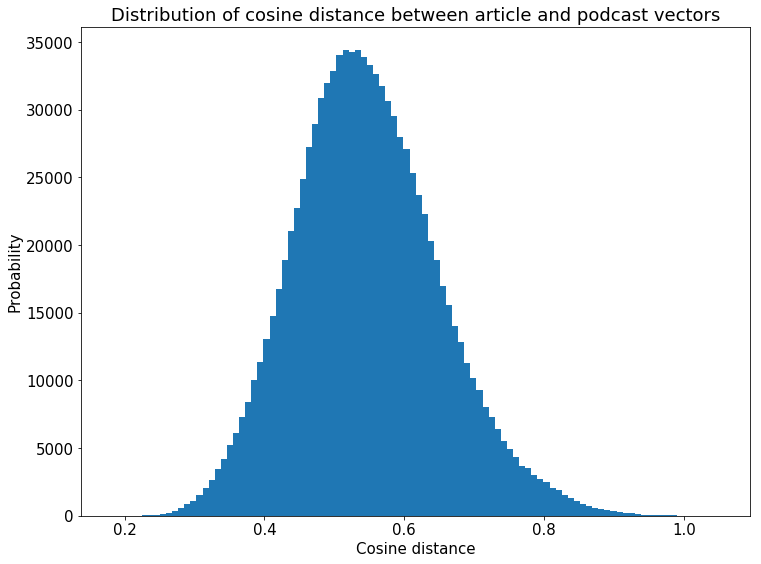

In [59]:
#Visualize similarity_distribution

import numpy as np
from matplotlib import pyplot as plt

similarity_data = np.array(similarity_matrix).flatten()
similarity_data = similarity_data[np.isnan(similarity_data)!=True]
print('Mean = %.4f, Std = %.4f' % (np.mean(similarity_data),np.std(similarity_data)))

#Make histogram
nbins = 100
plt.figure(figsize=[12,9])
plt.hist(similarity_data[np.isnan(similarity_data)!=True],bins=nbins)
plt.xlabel('Cosine distance')
plt.ylabel('Probability')
plt.title("Distribution of cosine distance between article and podcast vectors")

In [ ]:
comparator_function = scipy.spatial.distance.cosine

sample_size = 1000
sample_podcasts = podcastdb.podcastdb['w2v'].sample(sample_size)
sample_articles = articledb['content'].sample(sample_size)

similarity_matrix_body = [[comparator_function(p,podcastdb._evaluate(podcastdb.cleaner.preprocess_input(u))) for u in sample_articles.get_values()] for p in sample_podcasts.get_values()]

In [10]:
#Visualize similarity_distribution

import numpy as np
from matplotlib import pyplot as plt

similarity_data = np.array(similarity_matrix_body).flatten()
similarity_data = similarity_data[np.isnan(similarity_data)!=True]
print('Mean = %.4f, Std = %.4f' % (np.mean(similarity_data),np.std(similarity_data)))

#Make histogram
nbins = 100
plt.figure(figsize=[12,9])
plt.hist(similarity_data[np.isnan(similarity_data)!=True],bins=nbins)
plt.xlabel('Cosine distance')
plt.ylabel('Probability')
plt.title("Distribution of cosine distance between article and podcast vectors")

NameError: name 'similarity_matrix_body' is not defined